In [1]:
library(repr)
library(abind)
library(scales)
library(ggplot2)
library(IRdisplay)
library(RColorBrewer)
options(repr.plot.width=10, repr.plot.height=5)
if (getwd() != "/projects/ps-gymreklab/amassara/simulate_gwas") {
    setwd("/projects/ps-gymreklab/amassara/simulate_gwas")
}

In [2]:
gt = "out/1_98001984-99001984/gt_matrix.tsv.gz"
phen = "out/1_98001984-99001984/sim/str/0.5/phens.tsv.gz"
out = "out/1_98001984-99001984/susieR-notebook-output"
exclude_causal = FALSE
dir.create(out, showWarnings = FALSE)

In [3]:
# import genotype matrices as proper matrices
gt = read.csv(gt, sep="\t", header=T)
phen = read.csv(phen, sep="\t", header=T)
# create matrices without unecessary columns
X = as.matrix(gt[,-1])
storage.mode(X) = 'double'
y = as.matrix(phen[,ncol(phen)])
# what is the column name of the causal variant?
causal_variant = colnames(phen)[2]

In [4]:
# remove the causal variant if requested
if (exclude_causal) {
  X = X[,!(colnames(X) %in% c(causal_variant))]
}

In [5]:
# the number of samples and the number of variants:
n = nrow(X)
p = ncol(X)

In [6]:
# create vector with causal status
# this vector indicates which variant is truly causal
b = rep(0,p)
names(b) = colnames(X)
# causal_variant = 'X98501984.0' # SNP
# causal_variant = 'X98506615.1' # STR
if (exclude_causal) {
    b[causal_variant] = 1
}

In [7]:
mm_regression = function(X, Y, Z=NULL) {
  if (!is.null(Z)) {
      Z = as.matrix(Z)
  }
  reg = lapply(seq_len(ncol(Y)), function (i) simplify2array(susieR:::univariate_regression(X, Y[,i], Z)))
  reg = do.call(abind, c(reg, list(along=0)))
  # return array:
  #   out[1,,] is beta hat (the least-squares estimates of the coefficients)
  #   out[2,,] is se betahat (the standard errors of the beta hats)
  return(aperm(reg, c(3,2,1)))
}
sumstats = mm_regression(as.matrix(X), as.matrix(y))
dat = list(X=X,Y=as.matrix(y))
input = paste0(out,'/sumstats.rds')
saveRDS(list(data=dat, sumstats=sumstats), input)

In [8]:
output = paste0(out, "/N2finemapping.FINEMAP")
args = "--n-causal-snps 2"
commandArgs = function(...) 1

# source(paste0(.libPaths(), '/susieR/code/finemap.R'))
source("/projects/ps-gymreklab/amassara/simulate_gwas/temp/finemap.R")


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'readr'


The following object is masked from 'package:scales':

    col_factor




In [9]:
finemap = readRDS(paste0(out,"/N2finemapping.FINEMAP.rds"))[[1]]
head(finemap$snp)

,rank,snp,prob,prob_cumsum,log10bf,snp_prob
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,490,0.99993800,0.6243291,7.199030,0.99993800
2,2,40,0.01550950,0.6340128,1.189280,0.01550950
3,3,39,0.00660572,0.6381372,0.814689,0.00660572
4,4,68,0.00575768,0.6417321,0.754645,0.00575768
5,5,89,0.00575768,0.6453270,0.754645,0.00575768
6,6,73,0.00575756,0.6489218,0.754636,0.00575756


In [10]:
snp = finemap$snp
snp$snp = as.numeric(snp$snp)
snp = snp[order(snp$snp),]
# snp$b = as.character(b)
# snp$pos = as.integer(sub("X(\\S+)\\.", "\\1", colnames(X)))
pip = snp$snp_prob
# b_colors = c(`0`='black', `1`='red')
# snp$ld_causal = (as.vector(cor(X[,causal_variant], X))^2)^(2.5)
# plot(snp$pos, snp$ld_causal)

In [11]:
pdf(paste0(out,'/finemap.pdf'), width =5, height = 5, pointsize=16)
susieR::susie_plot(pip, y='PIP', b=b, main = 'Bayesian sparse regression')
dev.off()

png 
  2

In [12]:
display_pdf(file=paste0(out,'/finemap.pdf'))

In [13]:
fitted = susieR::susie(X, y, L=5,
               estimate_residual_variance=TRUE, 
               scaled_prior_variance=0.2,
               tol=1e-3, track_fit=TRUE, min_abs_corr=0.02)
susie_pip = fitted$pip[colnames(X)]

In [14]:
pdf(paste0(out,'/susie.pdf'), width =5, height = 5, pointsize=16)
susieR::susie_plot(fitted, y='PIP', b=b, max_cs=0.4, main = paste('SuSiE, ', length(fitted$sets$cs), 'CS identified'))
dev.off()

png 
  2

In [15]:
display_pdf(file=paste0(out,'/susie.pdf'))

## SuSiE Effect Size Estimate

In [16]:
bhat = coef(fitted)[-1]
pdf(paste0(out,'/susie_eff.pdf'), width =5, height = 5, pointsize=16)
susieR::susie_plot(bhat, y='bhat', b=b, main = 'SuSiE, effect size estimate') 
dev.off()

png 
  2

In [17]:
display_pdf(file=paste0(out,'/susie_eff.pdf'))

# Testing a New PIP Plot

In [18]:
finemap_results = finemap
X = as.matrix(gt[,-1])
storage.mode(X) = 'double'

In [22]:
b = rep(0, ncol(X))
names(b) = colnames(X)
if (exclude_causal) {
    b = b[!(names(b) %in% c(causal_variant))]
} else {
    b[causal_variant] = 1
}

# parse the finemap data
snp = finemap_results$snp
finemap_pip = snp[order(as.numeric(snp$snp)),]$snp_prob
susie_pip = fitted$pip

# define a function for PIP plotting
pip_plot = function(pips, X, b, susie_cs=NULL) {
    # create a ggplot of the PIPs
    # note that each of pips, X, and b must be ordered by variant POS
    # first, initialize the values we need
    b_colors = c(`0`='black', `1`='red')
    causal_var = names(b[b == 1])
    if (length(causal_var) == 0) {
        causal_var = X[,causal_variant]
        X = X[,!(colnames(X) %in% c(causal_variant))]
    } else {
        causal_var = X[,causal_var[1]]
    }
    data = data.frame(
        pip = pips,
        b = as.character(b),
        pos = as.integer(sub("X(\\S+)\\.", "\\1", names(b))),
        ld_causal = as.vector(cor(causal_var, X))^2
    )
    if (!is.null(susie_cs)) {
        data$cs = as.integer((names(b) %in% susie_cs))*2
    } else {
        data$cs = 0
    }
    # extract the causal variants to another data frame
    data_causal = data[data$b == '1',]
    # make the plot
    ggplot(data, aes(x=pos, y=pip)) +
    geom_point(aes(fill=ld_causal, stroke=cs, color=factor(cs)), size=7, shape=21) +
    scale_fill_gradient(name='LD with Causal Variant', low='#FBBA72', high='#691E06') +
    scale_color_manual(name='Credible Sets', values=c('transparent', '#7C9299'), guide="none") +
    geom_point(data=data_causal, aes(stroke=cs, color=factor(cs)), fill='red', size=7, shape=21) +
    xlab('Chromosomal Position') +
    ylab('Posterior Inclusion Probability (PIP)') + 
    ylim(0,1) +
    theme_grey(base_size=16)
}

null device 
          1

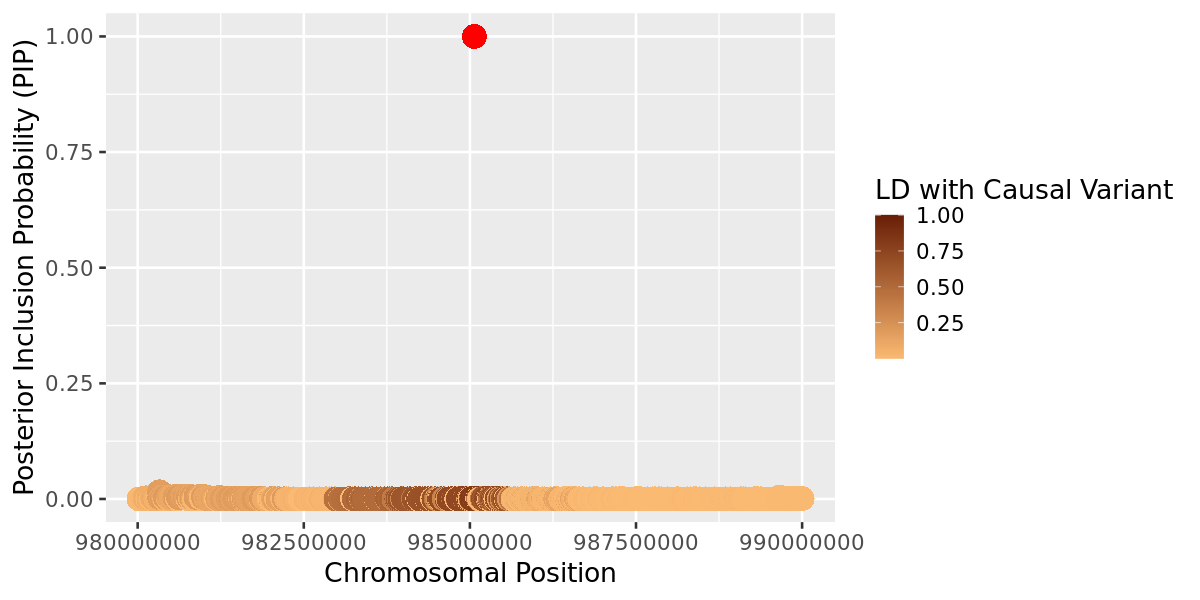

In [23]:
pip_plot(finemap_pip, X, b)
dev.off()
ggsave(paste0(out,'/finemap_improved.pdf'), width=10, height=5, device='pdf')

null device 
          1

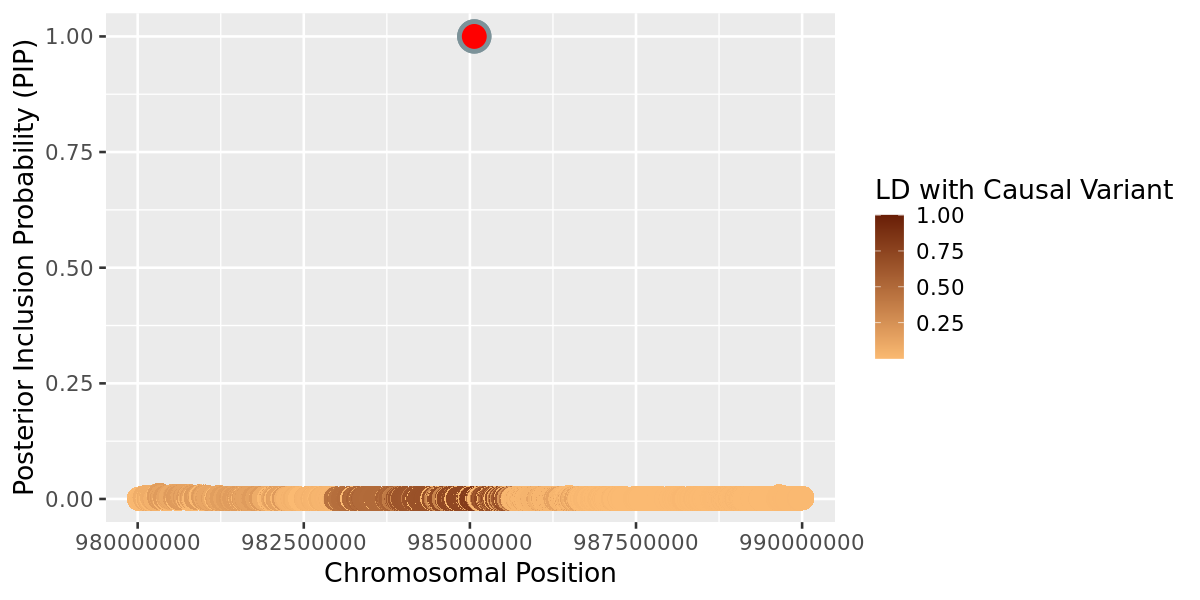

In [24]:
pip_plot(susie_pip, X, b, susie_cs=names(fitted$pip[fitted$sets$cs[['L1']]]))
dev.off()
ggsave(paste0(out,'/susie_improved.pdf'), width=10, height=5, device='pdf')